# GNN Decoder for BCH Codes

This notebook reproduces the (63,45) BCH results in the paper [Graph Neural Networks for Channel Decoding](https://arxiv.org/pdf/2207.14742.pdf).

**Remark**: the training can take several hours. However, pre-trained weights are stored in this repository and can be directly loaded to reproduce the results.

This notebook requires [Sionna](https://nvlabs.github.io/sionna/).

In [162]:
# general imports
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# load required Sionna components
from sionna.fec.utils import load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder

%load_ext autoreload
%autoreload 2
from gnn import * # load GNN functions
from wbp import * # load weighted BP functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 1
Only GPU number 0 used.


## Define Hyperparameters and Load Code

We define all parameters as dictionary to support different architectures for different codes.


In [174]:
#----- BCH -----
params={
    # --- Code Parameters ---
        "code": "BCH", # (63,45)
    # --- GNN Architecture ----
        "num_embed_dims": 20,
        "num_msg_dims": 20,
        "num_hidden_units": 40,
        "num_mlp_layers": 2,
        "num_iter": 8,
        "reduce_op": "mean",
        "activation": "tanh",
        "clip_llr_to": None,
        "use_attributes": False,
        "node_attribute_dims": 0,
        "msg_attribute_dims": 0,
        "use_bias": False,        
    # --- Training ---- # 
        "batch_size": [256, 256, 256], # bs, iter, lr must have same dim
        "train_iter": [35000, 300000, 300000],
        "learning_rate": [1e-3, 1e-4, 1e-5],
        "ebno_db_train_min": 2.,  # 3
        "ebno_db_train_max": 8.,
        "ebno_db_eval": 6.,
        "batch_size_eval": 10000, # batch size only used for evaluation during training
        "eval_train_steps": 1000, # evaluate model every N iters
    # --- Log ----
        "save_weights_iter": 10000, # save weights every X iters
        "run_name": "BCH_01", # name of the stored weights/logs
        "save_dir": "results/", # folder to store results
    # --- MC Simulation parameters ----
        "mc_iters": 1000,
        "mc_batch_size": 2000,
        "num_target_block_errors": 500,
        "ebno_db_min": 1.,  # 4.
        "ebno_db_max": 9., # 7.
        "ebno_db_stepsize": 1,
        "eval_iters": [2, 10],  # [2, 3, 4, 6, 8, 10]
    # --- Weighted BP parameters ----
        "simulate_wbp": False, # simulate weighted BP as baseline
        "wbp_batch_size" : [2000, 2000, 2000],
        "wbp_train_iter" : [300, 10000, 2000],
        "wbp_learning_rate" : [1e-2, 1e-3, 1e-3],
        "wbp_ebno_train" : [5., 5., 6.],
        "wbp_ebno_val" : 7., # validation SNR during training
        "wbp_batch_size_val" : 2000,
        "wbp_clip_value_grad" : 10, 
}

## Load / Generate the Graph

In [4]:
# all codes must provide an encoder-layer and a pcm
if params["code"]=="BCH":    
    print("Loading BCH code")
    pcm, k, n, coderate = load_parity_check_examples(pcm_id=1, verbose=True)

    encoder = LinearEncoder(pcm, is_pcm=True)
    params["k"] = k
    params["n"] = n
else:
    raise ValueError("Unknown code type")

Loading BCH code

n: 63, k: 45, coderate: 0.714


2023-06-04 16:25:53.011525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 16:25:55.257706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14625 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


## Simulate Baseline BER Performance

In [180]:
ber_plot = PlotBER(f"GNN-based Decoding - {params['code']}, (k,n)=({k},{n})")
ebno_dbs = np.arange(params["ebno_db_min"],
                     params["ebno_db_max"]+1,
                     params["ebno_db_stepsize"])

In [181]:
# uncoded QPSK
e2e_uncoded = E2EModel(None, None, k=100, n=100) # k and n are not relevant here
ber_plot.simulate(e2e_uncoded,
                  ebno_dbs=ebno_dbs,
                  batch_size=params["mc_batch_size"],
                  num_target_block_errors=params["num_target_block_errors"],
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=params["mc_iters"],
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 9.4185e-02 | 1.0000e+00 |       18837 |      200000 |         2000 |        2000 |         2.2 |reached target block errors
      2.0 | 7.1445e-02 | 1.0000e+00 |       14289 |      200000 |         2000 |        2000 |         0.0 |reached target block errors
      3.0 | 5.0460e-02 | 9.9500e-01 |       10092 |      200000 |         1990 |        2000 |         0.0 |reached target block errors
      4.0 | 3.3855e-02 | 9.6650e-01 |        6771 |      200000 |         1933 |        2000 |         0.0 |reached target block errors
      5.0 | 2.1600e-02 | 8.8250e-01 |        4320 |      200000 |         1765 |        2000 |         0.0 |reached target block errors
      6.0 | 1.2500e-02 | 7.1550e-01 |        2500 |      200000 |

In [182]:
# simulate "conventional" BP performance for given pcm
bp_decoder = LDPCBPDecoder(pcm, num_iter=20, hard_out=False)
e2e_bp = E2EModel(encoder, bp_decoder, k, n)
ber_plot.simulate(e2e_bp,
                 ebno_dbs=ebno_dbs,
                 batch_size=params["mc_batch_size"],
                 num_target_block_errors=params["num_target_block_errors"],
                 legend=f"BP {bp_decoder._num_iter.numpy()} iter.",
                 soft_estimates=True,
                 max_mc_iter=params["mc_iters"],
                 forward_keyboard_interrupt=False,
                 show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 1.2876e-01 | 9.9900e-01 |       16224 |      126000 |         1998 |        2000 |         3.0 |reached target block errors
      2.0 | 1.0549e-01 | 9.9350e-01 |       13292 |      126000 |         1987 |        2000 |         0.0 |reached target block errors
      3.0 | 7.7730e-02 | 9.2300e-01 |        9794 |      126000 |         1846 |        2000 |         0.0 |reached target block errors
      4.0 | 5.2548e-02 | 7.1650e-01 |        6621 |      126000 |         1433 |        2000 |         0.0 |reached target block errors
      5.0 | 2.8000e-02 | 4.2000e-01 |        3528 |      126000 |          840 |        2000 |         0.0 |reached target block errors
      6.0 | 1.1579e-02 | 1.7450e-01 |        2918 |      252000 |

In [ ]:
# train and simulate Weighted BP as additional baseline
# please note that the training parameters could be critical 
if params["simulate_wbp"]:
    evaluate_wbp(params, pcm, encoder, ebno_dbs, ber_plot)

### GNN-based Decoding


In [6]:
tf.random.set_seed(2) # we fix the seed to ensure stable convergence 

# init the GNN decoder
gnn_decoder = GNN_BP(pcm=pcm,
                     num_embed_dims=params["num_embed_dims"],
                     num_msg_dims=params["num_msg_dims"],
                     num_hidden_units=params["num_hidden_units"],
                     num_mlp_layers=params["num_mlp_layers"],
                     num_iter=params["num_iter"],
                     reduce_op=params["reduce_op"],
                     activation=params["activation"],
                     output_all_iter=True,
                     clip_llr_to=params["clip_llr_to"],
                     use_attributes=params["use_attributes"],
                     node_attribute_dims=params["node_attribute_dims"],
                     msg_attribute_dims=params["msg_attribute_dims"],
                     use_bias=params["use_bias"])
                     
e2e_gnn = E2EModel(encoder, gnn_decoder, k, n)

In [7]:
# init model and print summary
e2e_gnn(1, tf.convert_to_tensor([[1.]]))
e2e_gnn.summary()

2023-06-04 16:26:04.304693: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x22367aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-04 16:26:04.304735: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2023-06-04 16:26:04.955378: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. binary_source/random_uniform
2023-06-04 16:26:04.958015: W tensorflow/compiler/tf2xla/kernels/categorical_op.cc:128] Warning: Using tf.random.categorical with XLA compilation will ignore seeds.
2023-06-04 16:26:05.190322: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-04 16:26:05.901841: W tenso

Model: "e2e_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 binary_source (BinarySource  multiple                 0         
 )                                                               
                                                                 
 mapper (Mapper)             multiple                  0         
                                                                 
 demapper (Demapper)         multiple                  0         
                                                                 
 awgn (AWGN)                 multiple                  0         
                                                                 
 gnn_bp (GNN_BP)             multiple                  9640      
                                                                 
 linear_encoder (LinearEncod  multiple                 0         
 er)                                                     

2023-06-04 16:26:11.859762: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


and let's train the model

In [8]:
train = True # remark: training takes several hours
if train:
    train_gnn(e2e_gnn, params)
else:
    # you can also load the precomputed weights
    load_weights(e2e_gnn, "weights/BCH_precomputed.npy")

New training parameters - bs: 256, lr: 0.001, iters: 35000


2023-06-04 16:26:25.532444: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mapper/assert_greater_equal/Assert/Assert
2023-06-04 16:26:25.533957: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator awgn/assert_greater_equal/Assert/Assert
2023-06-04 16:26:25.533999: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator awgn/assert_less_equal/Assert/Assert
2023-06-04 16:26:25.534028: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator awgn/assert_greater_equal_1/Assert/Assert
2023-06-04 16:26:25.534054: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator demapper/symbol_logits2ll_rs_with_prior/assert_greater_equal/Assert/Assert
2023-06-04 16:26:25.534081: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator demapper/symbol_logits2ll_rs_with_prior/assert_less_equal/Assert/Assert
2023-06-04 16:26:25.534105: W tensorflow/compiler/

Iteration 1000, loss = 0.553, ber = 0.02657, duration: 80.52s
Iteration 2000, loss = 0.537, ber = 0.02434, duration: 52.45s
Iteration 3000, loss = 0.490, ber = 0.02155, duration: 52.14s
Iteration 4000, loss = 0.460, ber = 0.01980, duration: 51.95s
Iteration 5000, loss = 0.411, ber = 0.01663, duration: 51.96s
Iteration 6000, loss = 0.392, ber = 0.01500, duration: 51.88s
Iteration 7000, loss = 0.369, ber = 0.01404, duration: 51.75s
Iteration 8000, loss = 0.363, ber = 0.01360, duration: 51.69s
Iteration 9000, loss = 0.362, ber = 0.01368, duration: 51.49s
Iteration 10000, loss = 0.348, ber = 0.01271, duration: 51.35s
Iteration 11000, loss = 0.351, ber = 0.01342, duration: 51.54s
Iteration 12000, loss = 0.346, ber = 0.01270, duration: 51.60s
Iteration 13000, loss = 0.329, ber = 0.01184, duration: 51.34s
Iteration 14000, loss = 0.334, ber = 0.01205, duration: 51.51s
Iteration 15000, loss = 0.322, ber = 0.01167, duration: 50.93s
Iteration 16000, loss = 0.330, ber = 0.01210, duration: 50.51s
I

Iteration 130000, loss = 0.283, ber = 0.00996, duration: 46.30s
Iteration 131000, loss = 0.281, ber = 0.00971, duration: 48.86s
Iteration 132000, loss = 0.282, ber = 0.00984, duration: 48.61s
Iteration 133000, loss = 0.271, ber = 0.00916, duration: 48.80s
Iteration 134000, loss = 0.270, ber = 0.00927, duration: 48.79s
Iteration 135000, loss = 0.274, ber = 0.00961, duration: 48.73s
Iteration 136000, loss = 0.273, ber = 0.00933, duration: 46.43s
Iteration 137000, loss = 0.285, ber = 0.00990, duration: 48.84s
Iteration 138000, loss = 0.272, ber = 0.00937, duration: 49.03s
Iteration 139000, loss = 0.267, ber = 0.00897, duration: 48.81s
Iteration 140000, loss = 0.279, ber = 0.00977, duration: 48.66s
Iteration 141000, loss = 0.273, ber = 0.00939, duration: 48.78s
Iteration 142000, loss = 0.283, ber = 0.00984, duration: 46.28s
Iteration 143000, loss = 0.274, ber = 0.00933, duration: 48.73s
Iteration 144000, loss = 0.269, ber = 0.00917, duration: 48.69s
Iteration 145000, loss = 0.278, ber = 0.

Iteration 259000, loss = 0.272, ber = 0.00934, duration: 49.01s
Iteration 260000, loss = 0.273, ber = 0.00942, duration: 49.24s
Iteration 261000, loss = 0.280, ber = 0.00959, duration: 48.91s
Iteration 262000, loss = 0.270, ber = 0.00928, duration: 46.43s
Iteration 263000, loss = 0.271, ber = 0.00914, duration: 49.14s
Iteration 264000, loss = 0.270, ber = 0.00921, duration: 49.21s
Iteration 265000, loss = 0.275, ber = 0.00929, duration: 49.03s
Iteration 266000, loss = 0.274, ber = 0.00947, duration: 49.02s
Iteration 267000, loss = 0.276, ber = 0.00954, duration: 49.18s
Iteration 268000, loss = 0.277, ber = 0.00939, duration: 46.55s
Iteration 269000, loss = 0.271, ber = 0.00914, duration: 48.96s
Iteration 270000, loss = 0.278, ber = 0.00955, duration: 48.94s
Iteration 271000, loss = 0.279, ber = 0.00968, duration: 48.95s
Iteration 272000, loss = 0.274, ber = 0.00939, duration: 48.81s
Iteration 273000, loss = 0.276, ber = 0.00935, duration: 48.75s
Iteration 274000, loss = 0.275, ber = 0.

Iteration 387000, loss = 0.271, ber = 0.00907, duration: 48.68s
Iteration 388000, loss = 0.266, ber = 0.00910, duration: 46.24s
Iteration 389000, loss = 0.265, ber = 0.00902, duration: 48.70s
Iteration 390000, loss = 0.266, ber = 0.00894, duration: 48.62s
Iteration 391000, loss = 0.268, ber = 0.00919, duration: 48.70s
Iteration 392000, loss = 0.262, ber = 0.00877, duration: 48.57s
Iteration 393000, loss = 0.271, ber = 0.00914, duration: 48.58s
Iteration 394000, loss = 0.262, ber = 0.00887, duration: 46.17s
Iteration 395000, loss = 0.270, ber = 0.00917, duration: 48.65s
Iteration 396000, loss = 0.274, ber = 0.00926, duration: 48.53s
Iteration 397000, loss = 0.276, ber = 0.00941, duration: 48.60s
Iteration 398000, loss = 0.264, ber = 0.00893, duration: 48.65s
Iteration 399000, loss = 0.264, ber = 0.00908, duration: 48.70s
Iteration 400000, loss = 0.274, ber = 0.00922, duration: 46.16s
Iteration 401000, loss = 0.270, ber = 0.00923, duration: 48.62s
Iteration 402000, loss = 0.271, ber = 0.

Iteration 516000, loss = 0.265, ber = 0.00904, duration: 48.73s
Iteration 517000, loss = 0.263, ber = 0.00886, duration: 48.73s
Iteration 518000, loss = 0.271, ber = 0.00909, duration: 48.74s
Iteration 519000, loss = 0.264, ber = 0.00866, duration: 48.71s
Iteration 520000, loss = 0.261, ber = 0.00867, duration: 46.33s
Iteration 521000, loss = 0.260, ber = 0.00859, duration: 48.83s
Iteration 522000, loss = 0.272, ber = 0.00924, duration: 48.70s
Iteration 523000, loss = 0.271, ber = 0.00930, duration: 48.78s
Iteration 524000, loss = 0.270, ber = 0.00910, duration: 48.70s
Iteration 525000, loss = 0.270, ber = 0.00945, duration: 48.77s
Iteration 526000, loss = 0.261, ber = 0.00886, duration: 46.30s
Iteration 527000, loss = 0.263, ber = 0.00889, duration: 48.76s
Iteration 528000, loss = 0.265, ber = 0.00903, duration: 48.75s
Iteration 529000, loss = 0.267, ber = 0.00910, duration: 48.73s
Iteration 530000, loss = 0.264, ber = 0.00880, duration: 48.70s
Iteration 531000, loss = 0.270, ber = 0.

## Evaluate Final Performance

and store results...

2023-06-05 12:47:31.270709: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_9', 8 bytes spill stores, 8 bytes spill loads



EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 1.3315e-01 | 9.9950e-01 |       16777 |      126000 |         1999 |        2000 |         6.4 |reached target block errors
      2.0 | 1.0580e-01 | 9.9500e-01 |       13331 |      126000 |         1990 |        2000 |         0.0 |reached target block errors
      3.0 | 7.9833e-02 | 9.7500e-01 |       10059 |      126000 |         1950 |        2000 |         0.0 |reached target block errors
      4.0 | 5.5897e-02 | 8.9300e-01 |        7043 |      126000 |         1786 |        2000 |         0.0 |reached target block errors
      5.0 | 3.4857e-02 | 7.1800e-01 |        4392 |      126000 |         1436 |        2000 |         0.0 |reached target block errors
      6.0 | 1.7460e-02 | 4.4950e-01 |        2200 |      126000 |

2023-06-05 12:47:59.373011: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_73', 8 bytes spill stores, 8 bytes spill loads



EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 1.3208e-01 | 9.9700e-01 |       16642 |      126000 |         1994 |        2000 |        12.4 |reached target block errors
      2.0 | 1.0571e-01 | 9.7200e-01 |       13320 |      126000 |         1944 |        2000 |         0.1 |reached target block errors
      3.0 | 7.7968e-02 | 8.8800e-01 |        9824 |      126000 |         1776 |        2000 |         0.1 |reached target block errors
      4.0 | 4.9317e-02 | 6.9000e-01 |        6214 |      126000 |         1380 |        2000 |         0.1 |reached target block errors
      5.0 | 2.5381e-02 | 4.1950e-01 |        3198 |      126000 |          839 |        2000 |         0.1 |reached target block errors
      6.0 | 9.5397e-03 | 1.8375e-01 |        2404 |      252000 |

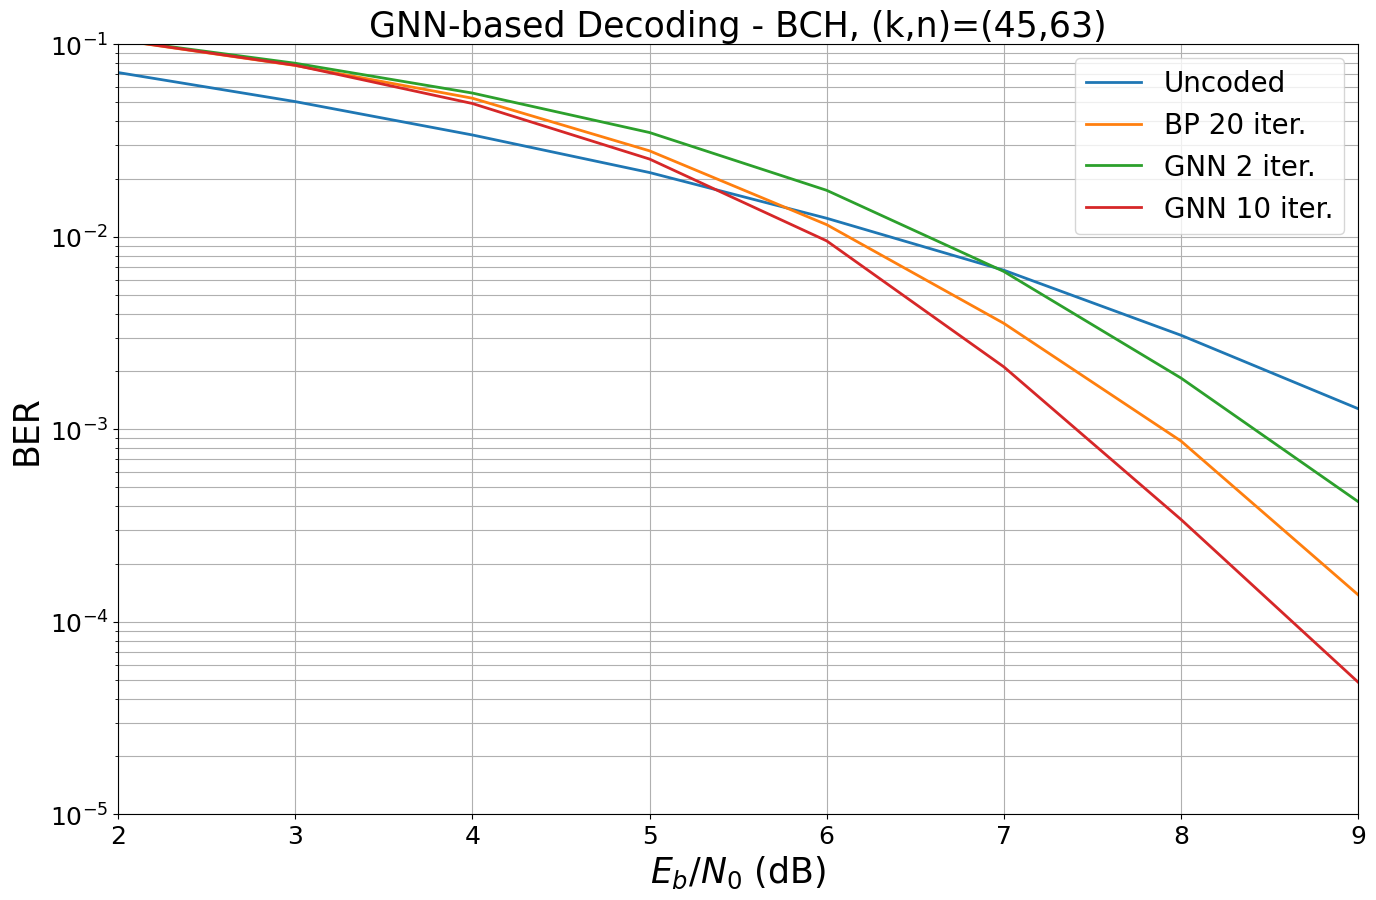

In [183]:
for iters in params["eval_iters"]:
    # instantiate new decoder for each number of iter (otherwise no retracing)
    gnn_dec_temp = GNN_BP(pcm=pcm,
                          num_embed_dims=params["num_embed_dims"],
                          num_msg_dims=params["num_msg_dims"],
                          num_hidden_units=params["num_hidden_units"],
                          num_mlp_layers=params["num_mlp_layers"],
                          num_iter=iters,
                          reduce_op=params["reduce_op"],
                          activation=params["activation"],
                          output_all_iter=False,
                          clip_llr_to=params["clip_llr_to"],
                          use_attributes=params["use_attributes"],
                          node_attribute_dims=params["node_attribute_dims"],
                          msg_attribute_dims=params["msg_attribute_dims"],
                          use_bias=params["use_bias"])
    # generate new model   
    model = E2EModel(encoder, gnn_dec_temp, k, n)
    model(1,1.) # init model
    # copy weights from trained decoder
    model._decoder.set_weights(gnn_decoder.get_weights())

    # and run the BER simulations
    ber_plot.simulate(model,
                     ebno_dbs=ebno_dbs,
                     batch_size=params["mc_batch_size"],
                     num_target_block_errors=500,
                     legend=f"GNN {iters} iter.",
                     soft_estimates=True,
                     max_mc_iter=params["mc_iters"],
                     forward_keyboard_interrupt=False,
                     show_fig=False);

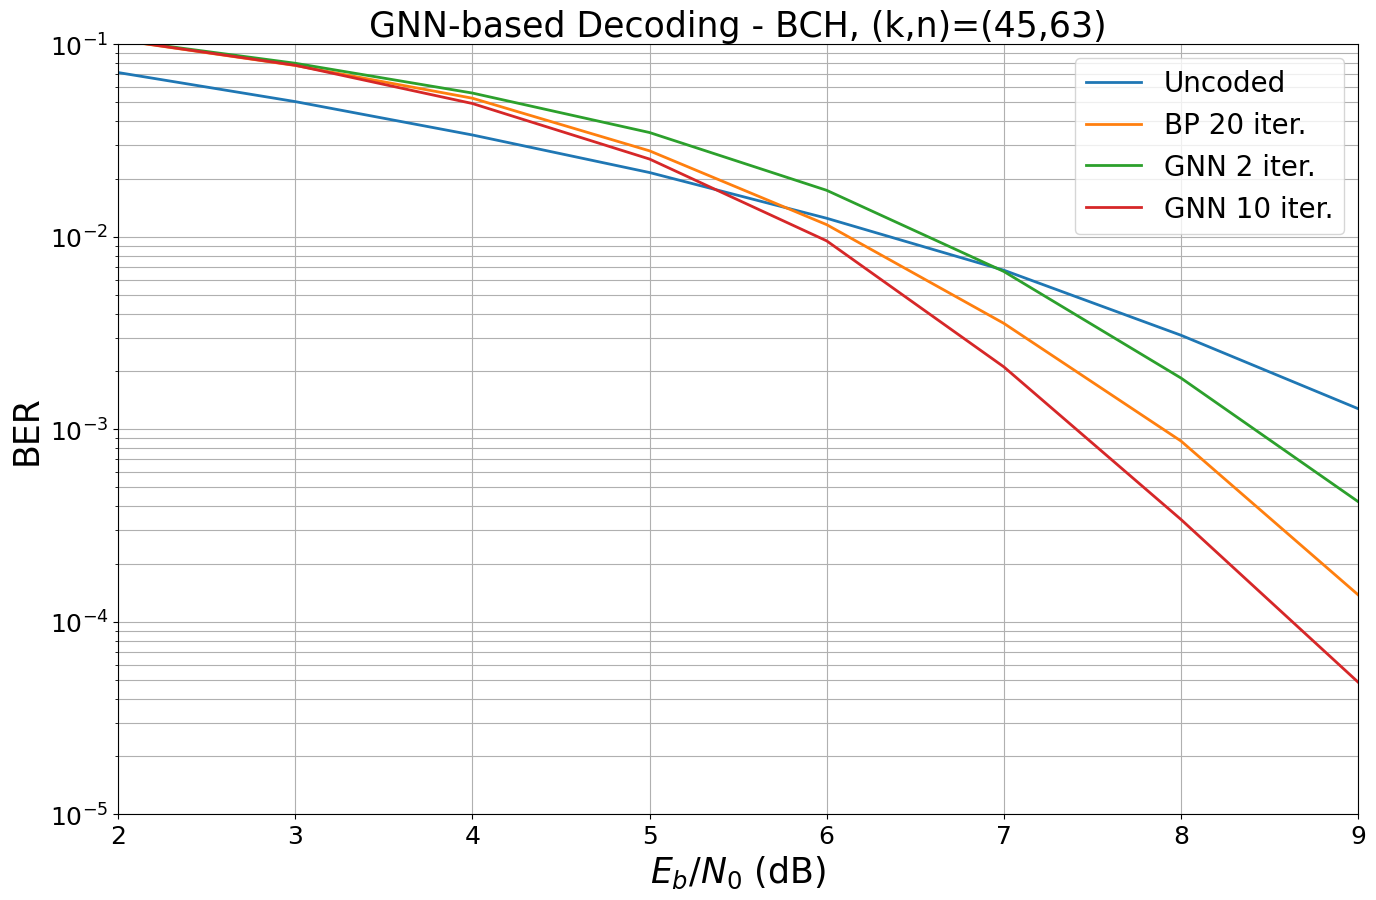

In [184]:
ber_plot(xlim=[2,9],ylim=[1e-5,0.1]) # show final figure

In [185]:
# export results for pgf plots
col_names = ["uncoded",  "bp-20"]
if params["simulate_wbp"]:
    col_names.append("wbp-20")
for it in params["eval_iters"]:
    col_names.append("gnn-" + str(it))
export_pgf(ber_plot, col_names)

snr, 	uncoded, 	bp-20, 	gnn-2, 	gnn-10, 	
1.000,	9.418500E-02,	1.287619E-01,	1.331508E-01,	1.320794E-01,	
2.000,	7.144500E-02,	1.054921E-01,	1.058016E-01,	1.057143E-01,	
3.000,	5.046000E-02,	7.773016E-02,	7.983333E-02,	7.796825E-02,	
4.000,	3.385500E-02,	5.254762E-02,	5.589683E-02,	4.931746E-02,	
5.000,	2.160000E-02,	2.800000E-02,	3.485714E-02,	2.538095E-02,	
6.000,	1.250000E-02,	1.157937E-02,	1.746032E-02,	9.539683E-03,	
7.000,	6.715000E-03,	3.557143E-03,	6.615079E-03,	2.113757E-03,	
8.000,	3.085000E-03,	8.704906E-04,	1.849206E-03,	3.406820E-04,	
9.000,	1.281667E-03,	1.383577E-04,	4.216931E-04,	4.865650E-05,	
10.000,	3.914286E-04,	1.713134E-05,	9.259259E-05,	6.080389E-06,	



In [151]:
batch_size = 3
ebno_db = tf.random.uniform([batch_size, 1],minval=1 ,maxval=2)

In [147]:
batch_size = 1
ebno_db = 2
no = ebnodb2no(ebno_db, 1, 45/63)

In [149]:
len(no.shape)

0

In [152]:
e2e_gnn(batch_size, ebno_db)

2023-06-05 11:55:05.156735: I tensorflow/stream_executor/gpu/asm_compiler.cc:323] ptxas warning : Registers are spilled to local memory in function 'fusion_67', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_71', 8 bytes spill stores, 8 bytes spill loads



(<tf.Tensor: shape=(3, 63), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
         0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
         0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
         0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
         1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
         1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.]],
       dtype=float32)>,
 [<tf.Tensor: shape=(3, 63), dtype=float32, numpy=
  array

In [84]:
binary_source = BinarySource()

In [85]:
b = binary_source([batch_size, 45])

In [86]:
c = encoder(b)
c_pad = tf.concat([c, tf.zeros([batch_size, 1])], axis=1)

In [87]:
mapper = Mapper("pam", 1)
demapper = Demapper("app", "pam", 1)
channel = AWGN()

In [88]:
x = mapper(c_pad)

In [96]:
print(no)

tf.Tensor([[0.8833402]], shape=(1, 1), dtype=float32)


In [89]:
if batch_size == 1:
    no = tf.reshape(no, [1,1])

In [90]:
no_list = tf.tile(no, [1, x.shape[1]])

In [91]:
no_list

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402,
        0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402,
        0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402,
        0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402,
        0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402,
        0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402,
        0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402,
        0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402,
        0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402,
        0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402, 0.8833402,
        0.8833402, 0.8833402, 0.8833402, 0.8833402]], dtype=float32)>

In [73]:
no_bernoulli = tf.cast(tf.random.categorical(tf.math.log(tf.tile([[0.5, 0.5]], [batch_size, 1])), 64), dtype=no.dtype)  # sample [0,1] with probability 0.5 for each bit of each codeword in the batch
no = no_list + tf.multiply(no_bernoulli, no)  # compute the original uniform variance plus the bursty variance
y = channel([x, no])
llr = demapper([y, no])

In [92]:
no_bernoulli

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.]],
      dtype=float32)>

In [186]:
y

<tf.Tensor: shape=(1, 64), dtype=complex64, numpy=
array([[-0.60173535+1.4953268j ,  1.9829578 +0.4453397j ,
         0.03323877+2.8085916j ,  1.4612823 +1.7450761j ,
         2.8119178 -0.45124096j,  0.7283861 +0.1049243j ,
        -1.5864432 +2.5406265j ,  0.64694536-0.57217836j,
        -0.71099854-0.02958402j,  0.71367955-1.0006766j ,
         0.9894965 -0.566463j  , -0.21103221+0.22568999j,
        -1.092136  +0.3887945j ,  0.47534543+0.04038462j,
         0.6711852 -0.06355609j,  2.990789  -0.5257676j ,
         0.317254  -0.53726214j, -1.180905  +0.705924j  ,
        -1.0463822 -0.6030762j ,  1.0278783 -0.77812076j,
        -1.2097121 -0.2916782j ,  1.0718307 +2.5800269j ,
        -0.2753039 +1.24951j   , -1.3108646 -1.1866928j ,
        -1.2256943 +0.6359105j ,  0.0595305 +0.27206314j,
        -0.10967207-0.30631232j,  0.8602338 +0.0823703j ,
        -1.236835  -0.8970194j ,  0.0523541 +0.22930144j,
         0.4873017 +0.61480045j, -1.4736719 -0.7528823j ,
         1.2682195 +2